***
    
Demo JAX for PINN (Physics-Informed Neural Network)
    
***

    Version: 2023-03-16
    
    Author : Nicholas Sung Wei Yong, Wong Jian Cheng, Ooi Chin Chun, Abhishek Gupta

    Contain:
    
    1. PINN for solving Linearized Burgers equation
    
    2. Optimize PINN using Stochastic gradient descent on the JAX framework
       -  as described in Nicholas Sung Wei Yong, Jian Cheng Wong, Pao-Hsiung Chiu, Abhishek Gupta, Chinchun Ooi, Yew-Soon Ong
       "Neuroevolution Surpasses Stochastic Gradient Descent for Physics-Informed Neural Networks" arXiv preprint arXiv:2212.07624 (2022).

Import Libraries

In [1]:
import jax
import optax
import time
import matplotlib.pyplot as plt
from typing import Any, Callable, Sequence, Optional
from jax import lax, random, numpy as jnp
import flax
from flax.core import freeze, unfreeze
from flax import linen as nn
from jax import random, grad, vmap, hessian, jacfwd, jit
from jax.config import config

# choose GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

PINN Architecture

In [2]:
node = 10
class PINNs(nn.Module):
    """PINNs"""
    def setup(self):
        self.layers = [nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(node, kernel_init = jax.nn.initializers.glorot_uniform()),
                       nn.tanh,
                       nn.Dense(1, kernel_init = jax.nn.initializers.glorot_uniform(), use_bias=False)]
    
    @nn.compact
    def __call__(self, inputs):
        # split the two variables, probably just by slicing
        x, t = inputs[:,0:1], inputs[:,1:2]
        
        def get_u(x, t):
            u = jnp.hstack([x, t])
            for i, lyr in enumerate(self.layers):
                u = lyr(u)
            return u
        
        u = get_u(x, t)
        
        # obtain u_t
        def get_u_t(get_u, x, t):
            u_t = jacfwd(get_u, 1)(x, t)
            return u_t
    
        u_t_vmap = vmap(get_u_t, in_axes=(None, 0, 0))
        u_t = u_t_vmap(get_u, x, t).reshape(-1,1) 
        
        #obtain u_x
        def get_u_x(get_u, x, t):
            u_x = jacfwd(get_u)(x, t)
            return u_x
        
        u_x_vmap = vmap(get_u_x, in_axes=(None, 0, 0))
        u_x = u_x_vmap(get_u, x, t).reshape(-1,1)  
        
        #obtain u_xx    
        def get_u_xx(get_u, x, t):
            u_xx = hessian(get_u)(x,t)
            return u_xx
        
        u_xx_vmap = vmap(get_u_xx, in_axes=(None, 0, 0))
        u_xx = u_xx_vmap(get_u, x, t).reshape(-1,1)
        
        action = jnp.hstack([u, u_x, u_xx, u_t])   
        return action

# initialize model
model = PINNs()    

In [3]:
# choose seed
seed = 1
key1, key2 = random.split(random.PRNGKey(seed))
a = random.normal(key1, [1,2]) # Dummy input
params = model.init(key2, a) # Initialization call

In [4]:
from evojax.util import get_params_format_fn
num_params, format_params_fn = get_params_format_fn(params)
num_params

260

Problem

In [5]:
def f_ic(x):
    return m*jnp.exp(-(k*x)**2)

Hyper parameters and data 

In [6]:
import numpy as np
import pandas as pd

In [7]:
vis = 0.02
c = 1

# initial condition
k = 2
m = 10

# spatial domain
x_l, x_u = -1.5, 4.5

# time domain: 0 - t_T
t_T = 2.0

sim = pd.read_csv('linear.csv')
sim = sim[sim.x <= 4.5]
sim['x'], sim['t'] = sim['x'], sim['t']
x_train = jnp.vstack([sim.x.values, sim.t.values]).T
y_train = sim[['u']].values
x = x_train[:,0:1].reshape(-1,1)
t = x_train[:,1:2].reshape(-1,1)

_train1 = np.argwhere(t != 0.0)[:, 0]
x_train1 = x[_train1].reshape(-1,1)
t_train1 = t[_train1].reshape(-1,1)
y_train1 = y_train[_train1].reshape(-1,1)

_train2 = np.argwhere(t == 0.0)[:, 0]
x_train2 = x[_train2].reshape(-1,1)
t_train2 = t[_train2].reshape(-1,1)
y_train2 = y_train[_train2].reshape(-1,1)

data_all = jnp.hstack([x,t])
label_all = y_train
data_pde = jnp.hstack([x_train1, t_train1])
label_pde = y_train1
data_bc = jnp.hstack([x_train2, t_train2])
label_bc = y_train2
label_pde.shape[0]

38600

Loss Function

In [8]:
# loss function parameter
lmbda = 1 #500

In [9]:
def loss(params, inputs):
    x = inputs[:,0:1].reshape(-1,1)
    t = inputs[:,1:2].reshape(-1,1)
    prediction = model.apply(format_params_fn(params), jnp.hstack([x, t]))
    u, u_x, u_xx, u_t = prediction[:,0:1], prediction[:,1:2], prediction[:,2:3], prediction[:,3:4]
    # ground truth
    t_u = f_ic(x) 
    _ic = jnp.where((jnp.equal(t, 0)), 1, 0)
    # _bc = ( jnp.equal(x, x_l) | jnp.equal(x, x_u) )
    ic_mse = jnp.sum(jnp.square((t_u - u)*_ic)) / jnp.sum(_ic)
    # PDE (physics laws) 
    pde = u_t + c*u_x - vis*u_xx
    # exclude BC points
    _pde = jnp.where((jnp.equal(t, 0)), 0, 1)
    pde = pde * _pde
    pde_mse = jnp.sum(jnp.square(pde)) / jnp.sum(_pde)
    pde_mse = pde_mse 
    loss = pde_mse + ic_mse    
    return loss
  
#loss_grad = jax.jit(jax.grad(loss))
loss_grad = jax.jit(jax.value_and_grad(loss))    

Weights Update

In [10]:
def update(params, opt_state, batch_data):
    loss_value, grad = loss_grad(params, batch_data)
    updates, opt_state = optimizer.update(grad, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

update = jit(update)

Initialization

In [11]:
# initial params
params = model.init(key2, a) # Initialization call

# flatten initial params
params = jax.flatten_util.ravel_pytree(params)[0]

Optimizer (SGD)

In [12]:
alpha = 0.01
optimizer = optax.sgd(learning_rate=alpha)
opt_state = optimizer.init(params)

Minibatching

In [13]:
BS_pde = 100
BS_bc = 5

def minibatch(train_iters):
    _batch_pde = jax.random.choice(random.PRNGKey(train_iters), label_pde.shape[0], (BS_pde,))
    _batch_bc = jax.random.choice(random.PRNGKey(train_iters), label_bc.shape[0], (BS_bc,))    
    batch_data = jnp.vstack([data_pde[_batch_pde], data_bc[_batch_bc]])
    return batch_data

minibatch = jit(minibatch)

Training 

In [14]:
# store weights
papas = {}
papas[0] = params

max_iters = 1500000
minloss = jnp.inf
fullbatchloss = jnp.inf
fullbatchloss_ls = []
runtime = 0
train_iters = 0
while (train_iters < max_iters) and (runtime < 60):
    # compute full batch loss (every 1 iterations)
    if (train_iters % 1 == 0):
        loss_value, _ = loss_grad(params, data_all)    
        fullbatchloss = min(fullbatchloss, loss_value)
    # mini-batching
    batch_data = minibatch(train_iters)
    # stochastic update
    start = time.time()
    params, opt_state, loss_value = update(params, opt_state, batch_data)
    end = time.time()
    # store hsitory.
    runtime += (end-start)   
    fullbatchloss_ls.append([train_iters, runtime, loss_value, fullbatchloss])
    # append weights
    save_iters = [100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000]
    if (train_iters in save_iters):
        papas[train_iters] = params
        #print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
    # store weights when the full-batch loss is smallest
    if fullbatchloss < minloss:
        print ('iter. = %d  time = %.2fs  loss = %.2e  min. (full batch) loss = %.2e'%(train_iters, runtime, loss_value, fullbatchloss))
        minloss = fullbatchloss
        papas[-1] = params
    train_iters += 1
              
# final train_iters
print (train_iters, minloss)

iter. = 0  time = 1.04s  loss = 3.23e+01  min. (full batch) loss = 1.05e+01
iter. = 1  time = 1.04s  loss = 1.48e+01  min. (full batch) loss = 9.98e+00
iter. = 2  time = 1.04s  loss = 2.49e-01  min. (full batch) loss = 9.71e+00
iter. = 3  time = 1.04s  loss = 1.53e-01  min. (full batch) loss = 9.68e+00
iter. = 7  time = 1.04s  loss = 3.62e+01  min. (full batch) loss = 9.31e+00
iter. = 8  time = 1.04s  loss = 2.39e-01  min. (full batch) loss = 8.83e+00
iter. = 10  time = 1.04s  loss = 1.34e+01  min. (full batch) loss = 8.78e+00
iter. = 11  time = 1.04s  loss = 2.99e+01  min. (full batch) loss = 8.55e+00
iter. = 12  time = 1.04s  loss = 6.29e+00  min. (full batch) loss = 8.21e+00
iter. = 13  time = 1.04s  loss = 1.53e+01  min. (full batch) loss = 8.04e+00
iter. = 14  time = 1.04s  loss = 2.23e+01  min. (full batch) loss = 7.90e+00
iter. = 15  time = 1.04s  loss = 1.44e+01  min. (full batch) loss = 7.60e+00
iter. = 16  time = 1.05s  loss = 1.55e+01  min. (full batch) loss = 7.46e+00
iter.

iter. = 191  time = 1.10s  loss = 3.72e-01  min. (full batch) loss = 6.83e-01
iter. = 192  time = 1.10s  loss = 4.88e-01  min. (full batch) loss = 6.62e-01
iter. = 195  time = 1.10s  loss = 8.29e-02  min. (full batch) loss = 6.28e-01
iter. = 196  time = 1.10s  loss = 1.88e-01  min. (full batch) loss = 6.22e-01
iter. = 197  time = 1.10s  loss = 2.11e-01  min. (full batch) loss = 6.21e-01
iter. = 200  time = 1.10s  loss = 1.45e+00  min. (full batch) loss = 5.90e-01
iter. = 201  time = 1.10s  loss = 1.18e+00  min. (full batch) loss = 5.71e-01
iter. = 203  time = 1.10s  loss = 3.45e-01  min. (full batch) loss = 5.64e-01
iter. = 204  time = 1.10s  loss = 2.52e-01  min. (full batch) loss = 5.24e-01
iter. = 205  time = 1.10s  loss = 2.28e-01  min. (full batch) loss = 5.15e-01
iter. = 209  time = 1.11s  loss = 2.48e+00  min. (full batch) loss = 4.96e-01
iter. = 211  time = 1.11s  loss = 1.62e-01  min. (full batch) loss = 4.76e-01
iter. = 214  time = 1.11s  loss = 1.17e-01  min. (full batch) lo

iter. = 525  time = 1.20s  loss = 6.91e-02  min. (full batch) loss = 4.49e-02
iter. = 533  time = 1.20s  loss = 7.56e-02  min. (full batch) loss = 4.36e-02
iter. = 534  time = 1.20s  loss = 1.55e-02  min. (full batch) loss = 4.22e-02
iter. = 535  time = 1.20s  loss = 2.69e-02  min. (full batch) loss = 4.14e-02
iter. = 536  time = 1.21s  loss = 7.74e-02  min. (full batch) loss = 4.08e-02
iter. = 537  time = 1.21s  loss = 3.65e-02  min. (full batch) loss = 4.08e-02
iter. = 542  time = 1.21s  loss = 3.70e-02  min. (full batch) loss = 4.08e-02
iter. = 547  time = 1.21s  loss = 1.70e-02  min. (full batch) loss = 4.03e-02
iter. = 548  time = 1.21s  loss = 1.52e-02  min. (full batch) loss = 3.96e-02
iter. = 552  time = 1.21s  loss = 2.70e-02  min. (full batch) loss = 3.90e-02
iter. = 557  time = 1.21s  loss = 4.16e-02  min. (full batch) loss = 3.79e-02
iter. = 558  time = 1.21s  loss = 3.13e-02  min. (full batch) loss = 3.78e-02
iter. = 571  time = 1.22s  loss = 3.81e-02  min. (full batch) lo

iter. = 1660  time = 1.54s  loss = 3.67e-02  min. (full batch) loss = 1.06e-02
iter. = 1676  time = 1.55s  loss = 1.23e-02  min. (full batch) loss = 1.05e-02
iter. = 1713  time = 1.56s  loss = 7.87e-03  min. (full batch) loss = 1.05e-02
iter. = 1758  time = 1.58s  loss = 1.31e-02  min. (full batch) loss = 1.02e-02
iter. = 1762  time = 1.58s  loss = 6.21e-03  min. (full batch) loss = 9.95e-03
iter. = 1763  time = 1.58s  loss = 6.07e-03  min. (full batch) loss = 9.73e-03
iter. = 1814  time = 1.60s  loss = 9.48e-03  min. (full batch) loss = 9.61e-03
iter. = 1875  time = 1.62s  loss = 1.51e-02  min. (full batch) loss = 9.47e-03
iter. = 1886  time = 1.63s  loss = 3.18e-03  min. (full batch) loss = 9.27e-03
iter. = 1887  time = 1.63s  loss = 1.11e-02  min. (full batch) loss = 9.25e-03
iter. = 1917  time = 1.64s  loss = 1.23e-02  min. (full batch) loss = 9.24e-03
iter. = 1969  time = 1.65s  loss = 1.90e-02  min. (full batch) loss = 9.16e-03
iter. = 1970  time = 1.65s  loss = 1.39e-02  min. (f

iter. = 4481  time = 2.41s  loss = 4.32e-03  min. (full batch) loss = 4.28e-03
iter. = 4482  time = 2.41s  loss = 4.63e-03  min. (full batch) loss = 4.27e-03
iter. = 4566  time = 2.44s  loss = 1.67e-03  min. (full batch) loss = 4.26e-03
iter. = 4570  time = 2.44s  loss = 4.22e-03  min. (full batch) loss = 4.25e-03
iter. = 4604  time = 2.45s  loss = 3.91e-03  min. (full batch) loss = 4.23e-03
iter. = 4669  time = 2.47s  loss = 4.77e-03  min. (full batch) loss = 4.13e-03
iter. = 4746  time = 2.49s  loss = 3.24e-03  min. (full batch) loss = 4.09e-03
iter. = 4756  time = 2.50s  loss = 5.67e-03  min. (full batch) loss = 4.08e-03
iter. = 4775  time = 2.50s  loss = 3.75e-03  min. (full batch) loss = 4.04e-03
iter. = 4814  time = 2.51s  loss = 3.01e-03  min. (full batch) loss = 4.01e-03
iter. = 4826  time = 2.52s  loss = 3.86e-03  min. (full batch) loss = 3.99e-03
iter. = 4918  time = 2.55s  loss = 2.76e-03  min. (full batch) loss = 3.98e-03
iter. = 4928  time = 2.55s  loss = 3.71e-03  min. (f

iter. = 8827  time = 3.82s  loss = 2.74e-03  min. (full batch) loss = 2.28e-03
iter. = 8896  time = 3.84s  loss = 2.73e-03  min. (full batch) loss = 2.28e-03
iter. = 8948  time = 3.86s  loss = 1.39e-03  min. (full batch) loss = 2.28e-03
iter. = 8976  time = 3.87s  loss = 1.89e-03  min. (full batch) loss = 2.28e-03
iter. = 8982  time = 3.87s  loss = 2.08e-03  min. (full batch) loss = 2.26e-03
iter. = 9070  time = 3.90s  loss = 1.01e-03  min. (full batch) loss = 2.25e-03
iter. = 9146  time = 3.93s  loss = 2.42e-03  min. (full batch) loss = 2.25e-03
iter. = 9160  time = 3.93s  loss = 2.57e-03  min. (full batch) loss = 2.23e-03
iter. = 9161  time = 3.93s  loss = 3.59e-03  min. (full batch) loss = 2.22e-03
iter. = 9162  time = 3.93s  loss = 1.93e-03  min. (full batch) loss = 2.21e-03
iter. = 9193  time = 3.94s  loss = 1.21e-03  min. (full batch) loss = 2.20e-03
iter. = 9194  time = 3.94s  loss = 1.55e-03  min. (full batch) loss = 2.19e-03
iter. = 9237  time = 3.95s  loss = 2.01e-03  min. (f

iter. = 14362  time = 5.58s  loss = 2.49e-03  min. (full batch) loss = 1.48e-03
iter. = 14387  time = 5.59s  loss = 1.28e-03  min. (full batch) loss = 1.48e-03
iter. = 14424  time = 5.60s  loss = 1.09e-03  min. (full batch) loss = 1.47e-03
iter. = 14482  time = 5.62s  loss = 1.57e-03  min. (full batch) loss = 1.46e-03
iter. = 14586  time = 5.65s  loss = 9.60e-04  min. (full batch) loss = 1.46e-03
iter. = 14608  time = 5.65s  loss = 1.16e-03  min. (full batch) loss = 1.46e-03
iter. = 14638  time = 5.66s  loss = 5.51e-04  min. (full batch) loss = 1.46e-03
iter. = 14639  time = 5.66s  loss = 2.05e-03  min. (full batch) loss = 1.45e-03
iter. = 14707  time = 5.68s  loss = 6.32e-04  min. (full batch) loss = 1.45e-03
iter. = 14884  time = 5.74s  loss = 1.84e-03  min. (full batch) loss = 1.43e-03
iter. = 14911  time = 5.75s  loss = 5.17e-04  min. (full batch) loss = 1.43e-03
iter. = 14959  time = 5.77s  loss = 1.09e-03  min. (full batch) loss = 1.43e-03
iter. = 14977  time = 5.77s  loss = 2.00

iter. = 21435  time = 7.91s  loss = 1.14e-03  min. (full batch) loss = 1.03e-03
iter. = 21455  time = 7.91s  loss = 5.47e-04  min. (full batch) loss = 1.03e-03
iter. = 21498  time = 7.93s  loss = 9.42e-04  min. (full batch) loss = 1.03e-03
iter. = 21521  time = 7.93s  loss = 1.43e-03  min. (full batch) loss = 1.03e-03
iter. = 21548  time = 7.94s  loss = 6.27e-04  min. (full batch) loss = 1.02e-03
iter. = 21554  time = 7.94s  loss = 1.41e-03  min. (full batch) loss = 1.01e-03
iter. = 21664  time = 7.97s  loss = 5.58e-04  min. (full batch) loss = 1.01e-03
iter. = 21768  time = 8.01s  loss = 1.45e-03  min. (full batch) loss = 1.01e-03
iter. = 21975  time = 8.08s  loss = 1.36e-03  min. (full batch) loss = 1.00e-03
iter. = 22144  time = 8.15s  loss = 1.75e-03  min. (full batch) loss = 1.00e-03
iter. = 22168  time = 8.15s  loss = 1.38e-03  min. (full batch) loss = 9.96e-04
iter. = 22299  time = 8.20s  loss = 1.54e-03  min. (full batch) loss = 9.93e-04
iter. = 22339  time = 8.21s  loss = 4.44

iter. = 30254  time = 10.69s  loss = 8.83e-04  min. (full batch) loss = 7.26e-04
iter. = 30312  time = 10.71s  loss = 3.56e-04  min. (full batch) loss = 7.23e-04
iter. = 30345  time = 10.72s  loss = 6.69e-04  min. (full batch) loss = 7.19e-04
iter. = 30616  time = 10.81s  loss = 3.14e-04  min. (full batch) loss = 7.15e-04
iter. = 30617  time = 10.81s  loss = 4.68e-04  min. (full batch) loss = 7.15e-04
iter. = 30645  time = 10.82s  loss = 9.00e-04  min. (full batch) loss = 7.15e-04
iter. = 30663  time = 10.82s  loss = 8.05e-04  min. (full batch) loss = 7.13e-04
iter. = 30665  time = 10.82s  loss = 5.02e-04  min. (full batch) loss = 7.09e-04
iter. = 30776  time = 10.86s  loss = 1.27e-03  min. (full batch) loss = 7.07e-04
iter. = 30885  time = 10.90s  loss = 4.37e-04  min. (full batch) loss = 7.07e-04
iter. = 30934  time = 10.91s  loss = 1.49e-03  min. (full batch) loss = 7.05e-04
iter. = 31080  time = 10.96s  loss = 7.08e-04  min. (full batch) loss = 7.04e-04
iter. = 31098  time = 10.96s

iter. = 37939  time = 13.11s  loss = 6.29e-04  min. (full batch) loss = 5.60e-04
iter. = 37968  time = 13.12s  loss = 3.23e-04  min. (full batch) loss = 5.59e-04
iter. = 37969  time = 13.12s  loss = 6.83e-04  min. (full batch) loss = 5.58e-04
iter. = 37970  time = 13.12s  loss = 5.25e-04  min. (full batch) loss = 5.57e-04
iter. = 38131  time = 13.17s  loss = 3.53e-04  min. (full batch) loss = 5.56e-04
iter. = 38132  time = 13.17s  loss = 5.05e-04  min. (full batch) loss = 5.53e-04
iter. = 38382  time = 13.25s  loss = 4.93e-04  min. (full batch) loss = 5.51e-04
iter. = 38429  time = 13.27s  loss = 4.74e-04  min. (full batch) loss = 5.51e-04
iter. = 38553  time = 13.30s  loss = 7.00e-04  min. (full batch) loss = 5.49e-04
iter. = 38556  time = 13.30s  loss = 2.92e-04  min. (full batch) loss = 5.49e-04
iter. = 38623  time = 13.33s  loss = 5.33e-04  min. (full batch) loss = 5.48e-04
iter. = 38637  time = 13.33s  loss = 3.65e-04  min. (full batch) loss = 5.47e-04
iter. = 38677  time = 13.35s

iter. = 45898  time = 15.61s  loss = 2.75e-04  min. (full batch) loss = 4.47e-04
iter. = 45904  time = 15.61s  loss = 4.29e-04  min. (full batch) loss = 4.45e-04
iter. = 45928  time = 15.62s  loss = 2.93e-04  min. (full batch) loss = 4.44e-04
iter. = 46001  time = 15.64s  loss = 1.94e-04  min. (full batch) loss = 4.43e-04
iter. = 46024  time = 15.65s  loss = 3.35e-04  min. (full batch) loss = 4.41e-04
iter. = 46348  time = 15.75s  loss = 1.02e-03  min. (full batch) loss = 4.41e-04
iter. = 46414  time = 15.77s  loss = 2.51e-04  min. (full batch) loss = 4.40e-04
iter. = 46425  time = 15.77s  loss = 5.57e-04  min. (full batch) loss = 4.38e-04
iter. = 46517  time = 15.81s  loss = 4.82e-04  min. (full batch) loss = 4.38e-04
iter. = 46556  time = 15.82s  loss = 2.99e-04  min. (full batch) loss = 4.38e-04
iter. = 46568  time = 15.82s  loss = 6.48e-04  min. (full batch) loss = 4.38e-04
iter. = 46569  time = 15.82s  loss = 2.80e-04  min. (full batch) loss = 4.36e-04
iter. = 46834  time = 15.90s

iter. = 55108  time = 18.61s  loss = 4.82e-04  min. (full batch) loss = 3.57e-04
iter. = 55187  time = 18.63s  loss = 5.17e-04  min. (full batch) loss = 3.55e-04
iter. = 55263  time = 18.66s  loss = 2.49e-04  min. (full batch) loss = 3.55e-04
iter. = 55264  time = 18.66s  loss = 3.29e-04  min. (full batch) loss = 3.54e-04
iter. = 55507  time = 18.74s  loss = 1.75e-04  min. (full batch) loss = 3.54e-04
iter. = 55623  time = 18.77s  loss = 6.77e-04  min. (full batch) loss = 3.53e-04
iter. = 55651  time = 18.78s  loss = 7.34e-04  min. (full batch) loss = 3.53e-04
iter. = 55670  time = 18.78s  loss = 3.64e-04  min. (full batch) loss = 3.53e-04
iter. = 55715  time = 18.80s  loss = 7.43e-04  min. (full batch) loss = 3.53e-04
iter. = 55761  time = 18.81s  loss = 6.43e-04  min. (full batch) loss = 3.52e-04
iter. = 55782  time = 18.82s  loss = 3.78e-04  min. (full batch) loss = 3.51e-04
iter. = 55973  time = 18.88s  loss = 3.82e-04  min. (full batch) loss = 3.50e-04
iter. = 56130  time = 18.94s

iter. = 65084  time = 21.84s  loss = 1.17e-04  min. (full batch) loss = 2.91e-04
iter. = 65435  time = 21.95s  loss = 4.44e-04  min. (full batch) loss = 2.90e-04
iter. = 65463  time = 21.96s  loss = 1.71e-04  min. (full batch) loss = 2.90e-04
iter. = 65464  time = 21.96s  loss = 1.88e-04  min. (full batch) loss = 2.89e-04
iter. = 65922  time = 22.12s  loss = 2.86e-04  min. (full batch) loss = 2.87e-04
iter. = 65940  time = 22.12s  loss = 3.05e-04  min. (full batch) loss = 2.87e-04
iter. = 66039  time = 22.16s  loss = 4.24e-04  min. (full batch) loss = 2.87e-04
iter. = 66122  time = 22.18s  loss = 1.63e-04  min. (full batch) loss = 2.86e-04
iter. = 66149  time = 22.19s  loss = 2.33e-04  min. (full batch) loss = 2.86e-04
iter. = 66335  time = 22.26s  loss = 4.28e-04  min. (full batch) loss = 2.85e-04
iter. = 66417  time = 22.28s  loss = 1.06e-04  min. (full batch) loss = 2.85e-04
iter. = 66418  time = 22.29s  loss = 2.02e-04  min. (full batch) loss = 2.85e-04
iter. = 66485  time = 22.31s

iter. = 76108  time = 25.26s  loss = 3.74e-04  min. (full batch) loss = 2.43e-04
iter. = 76178  time = 25.28s  loss = 2.41e-04  min. (full batch) loss = 2.43e-04
iter. = 76185  time = 25.28s  loss = 1.61e-04  min. (full batch) loss = 2.42e-04
iter. = 76383  time = 25.35s  loss = 2.65e-04  min. (full batch) loss = 2.41e-04
iter. = 76630  time = 25.42s  loss = 1.69e-04  min. (full batch) loss = 2.41e-04
iter. = 76631  time = 25.42s  loss = 2.87e-04  min. (full batch) loss = 2.40e-04
iter. = 76778  time = 25.46s  loss = 1.57e-04  min. (full batch) loss = 2.39e-04
iter. = 77091  time = 25.58s  loss = 1.75e-04  min. (full batch) loss = 2.38e-04
iter. = 77229  time = 25.62s  loss = 1.16e-04  min. (full batch) loss = 2.38e-04
iter. = 77498  time = 25.70s  loss = 3.51e-04  min. (full batch) loss = 2.37e-04
iter. = 77652  time = 25.75s  loss = 3.01e-04  min. (full batch) loss = 2.36e-04
iter. = 77786  time = 25.80s  loss = 3.45e-04  min. (full batch) loss = 2.36e-04
iter. = 77883  time = 25.83s

iter. = 87441  time = 28.89s  loss = 1.75e-04  min. (full batch) loss = 2.05e-04
iter. = 87546  time = 28.93s  loss = 1.09e-04  min. (full batch) loss = 2.05e-04
iter. = 87547  time = 28.93s  loss = 2.01e-04  min. (full batch) loss = 2.05e-04
iter. = 87743  time = 28.99s  loss = 7.49e-05  min. (full batch) loss = 2.05e-04
iter. = 87857  time = 29.03s  loss = 1.83e-04  min. (full batch) loss = 2.05e-04
iter. = 87867  time = 29.03s  loss = 3.62e-04  min. (full batch) loss = 2.04e-04
iter. = 88179  time = 29.14s  loss = 2.52e-04  min. (full batch) loss = 2.04e-04
iter. = 88240  time = 29.16s  loss = 1.46e-04  min. (full batch) loss = 2.03e-04
iter. = 88434  time = 29.22s  loss = 1.81e-04  min. (full batch) loss = 2.03e-04
iter. = 88621  time = 29.28s  loss = 1.48e-04  min. (full batch) loss = 2.02e-04
iter. = 88630  time = 29.28s  loss = 1.29e-04  min. (full batch) loss = 2.02e-04
iter. = 88633  time = 29.28s  loss = 2.11e-04  min. (full batch) loss = 2.02e-04
iter. = 88814  time = 29.34s

iter. = 100608  time = 33.15s  loss = 1.01e-04  min. (full batch) loss = 1.74e-04
iter. = 100981  time = 33.27s  loss = 1.36e-04  min. (full batch) loss = 1.74e-04
iter. = 100982  time = 33.27s  loss = 1.72e-04  min. (full batch) loss = 1.74e-04
iter. = 101255  time = 33.35s  loss = 2.30e-04  min. (full batch) loss = 1.74e-04
iter. = 101452  time = 33.40s  loss = 1.25e-04  min. (full batch) loss = 1.73e-04
iter. = 101658  time = 33.47s  loss = 1.39e-04  min. (full batch) loss = 1.73e-04
iter. = 101802  time = 33.52s  loss = 1.25e-04  min. (full batch) loss = 1.73e-04
iter. = 101828  time = 33.52s  loss = 1.21e-04  min. (full batch) loss = 1.72e-04
iter. = 102183  time = 33.63s  loss = 8.85e-05  min. (full batch) loss = 1.72e-04
iter. = 102184  time = 33.63s  loss = 1.30e-04  min. (full batch) loss = 1.71e-04
iter. = 102371  time = 33.69s  loss = 1.35e-04  min. (full batch) loss = 1.71e-04
iter. = 102529  time = 33.73s  loss = 2.50e-04  min. (full batch) loss = 1.71e-04
iter. = 102533  

iter. = 114057  time = 37.45s  loss = 2.05e-04  min. (full batch) loss = 1.52e-04
iter. = 114060  time = 37.45s  loss = 1.94e-04  min. (full batch) loss = 1.51e-04
iter. = 114159  time = 37.48s  loss = 8.25e-05  min. (full batch) loss = 1.51e-04
iter. = 114171  time = 37.49s  loss = 4.99e-05  min. (full batch) loss = 1.51e-04
iter. = 114190  time = 37.49s  loss = 1.10e-04  min. (full batch) loss = 1.51e-04
iter. = 114209  time = 37.50s  loss = 1.05e-04  min. (full batch) loss = 1.50e-04
iter. = 114606  time = 37.62s  loss = 5.19e-05  min. (full batch) loss = 1.50e-04
iter. = 114992  time = 37.75s  loss = 1.50e-04  min. (full batch) loss = 1.50e-04
iter. = 115033  time = 37.77s  loss = 9.62e-05  min. (full batch) loss = 1.50e-04
iter. = 115347  time = 37.87s  loss = 1.70e-04  min. (full batch) loss = 1.49e-04
iter. = 115626  time = 37.96s  loss = 2.55e-04  min. (full batch) loss = 1.49e-04
iter. = 116024  time = 38.09s  loss = 1.44e-04  min. (full batch) loss = 1.48e-04
iter. = 116224  

iter. = 131094  time = 42.82s  loss = 7.13e-05  min. (full batch) loss = 1.29e-04
iter. = 131225  time = 42.86s  loss = 1.34e-04  min. (full batch) loss = 1.29e-04
iter. = 131296  time = 42.88s  loss = 1.00e-04  min. (full batch) loss = 1.29e-04
iter. = 131298  time = 42.88s  loss = 3.04e-04  min. (full batch) loss = 1.28e-04
iter. = 131766  time = 43.03s  loss = 1.46e-04  min. (full batch) loss = 1.28e-04
iter. = 132097  time = 43.13s  loss = 1.14e-04  min. (full batch) loss = 1.28e-04
iter. = 132218  time = 43.17s  loss = 1.41e-04  min. (full batch) loss = 1.28e-04
iter. = 132238  time = 43.18s  loss = 1.96e-04  min. (full batch) loss = 1.27e-04
iter. = 132680  time = 43.30s  loss = 1.44e-04  min. (full batch) loss = 1.27e-04
iter. = 132681  time = 43.30s  loss = 4.98e-05  min. (full batch) loss = 1.27e-04
iter. = 132726  time = 43.32s  loss = 3.46e-05  min. (full batch) loss = 1.27e-04
iter. = 133340  time = 43.51s  loss = 1.01e-04  min. (full batch) loss = 1.27e-04
iter. = 133477  

iter. = 150736  time = 48.74s  loss = 2.04e-04  min. (full batch) loss = 1.10e-04
iter. = 150741  time = 48.74s  loss = 1.00e-04  min. (full batch) loss = 1.10e-04
iter. = 151124  time = 48.84s  loss = 1.07e-04  min. (full batch) loss = 1.10e-04
iter. = 151454  time = 48.93s  loss = 9.89e-05  min. (full batch) loss = 1.10e-04
iter. = 151558  time = 48.96s  loss = 6.17e-05  min. (full batch) loss = 1.10e-04
iter. = 151579  time = 48.96s  loss = 8.53e-05  min. (full batch) loss = 1.10e-04
iter. = 151794  time = 49.03s  loss = 1.05e-04  min. (full batch) loss = 1.09e-04
iter. = 152027  time = 49.10s  loss = 1.66e-04  min. (full batch) loss = 1.09e-04
iter. = 152060  time = 49.11s  loss = 8.52e-05  min. (full batch) loss = 1.09e-04
iter. = 152223  time = 49.16s  loss = 1.70e-04  min. (full batch) loss = 1.09e-04
iter. = 152749  time = 49.33s  loss = 1.21e-04  min. (full batch) loss = 1.09e-04
iter. = 152777  time = 49.34s  loss = 1.13e-04  min. (full batch) loss = 1.09e-04
iter. = 153117  

iter. = 173962  time = 55.62s  loss = 3.73e-05  min. (full batch) loss = 9.46e-05
iter. = 174204  time = 55.69s  loss = 1.41e-04  min. (full batch) loss = 9.44e-05
iter. = 174311  time = 55.72s  loss = 6.70e-05  min. (full batch) loss = 9.43e-05
iter. = 174312  time = 55.72s  loss = 1.79e-04  min. (full batch) loss = 9.42e-05
iter. = 174641  time = 55.84s  loss = 7.98e-05  min. (full batch) loss = 9.40e-05
iter. = 175060  time = 55.96s  loss = 1.60e-04  min. (full batch) loss = 9.39e-05
iter. = 175343  time = 56.04s  loss = 8.64e-05  min. (full batch) loss = 9.38e-05
iter. = 175652  time = 56.14s  loss = 2.63e-04  min. (full batch) loss = 9.37e-05
iter. = 175713  time = 56.16s  loss = 8.00e-05  min. (full batch) loss = 9.36e-05
iter. = 175721  time = 56.16s  loss = 1.42e-04  min. (full batch) loss = 9.36e-05
iter. = 175887  time = 56.22s  loss = 7.94e-05  min. (full batch) loss = 9.35e-05
iter. = 175949  time = 56.24s  loss = 3.09e-05  min. (full batch) loss = 9.34e-05
iter. = 175951  

In [15]:
# process results
import numpy as np
import pandas as pd

In [16]:
fullbatchloss_ls = np.array(fullbatchloss_ls)
# write convergence history to file
# df = pd.DataFrame(fullbatchloss_ls, columns=[['Training Iteration', 'Training Time', 'Minibatch Loss', 'Fullbatch Loss']])
# df.to_csv('linear_sgd_minibatch_%d.csv'%(seed), index=False)
# df
fullbatchloss_ls[-1]

array([1.88106000e+05, 6.00007617e+01, 5.51225930e-05, 8.70868826e-05])

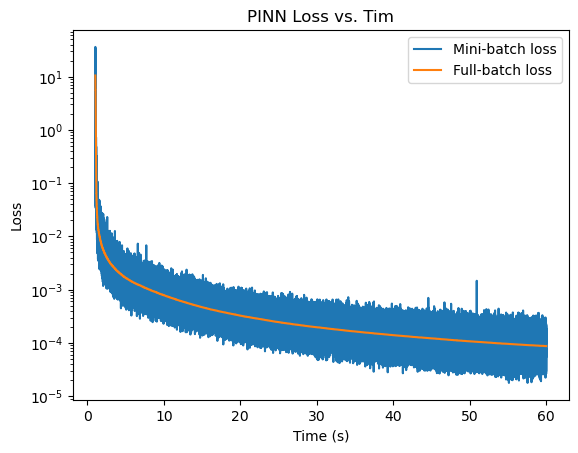

In [17]:
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 2], label='Mini-batch loss'); plt.yscale('log');
plt.plot(fullbatchloss_ls[:, 1], fullbatchloss_ls[:, 3], label='Full-batch loss');
plt.title('PINN Loss vs. Tim'); plt.xlabel('Time (s)'); plt.ylabel('Loss'); plt.legend();

#### Visualize results

DeviceArray(0.00050907, dtype=float32)

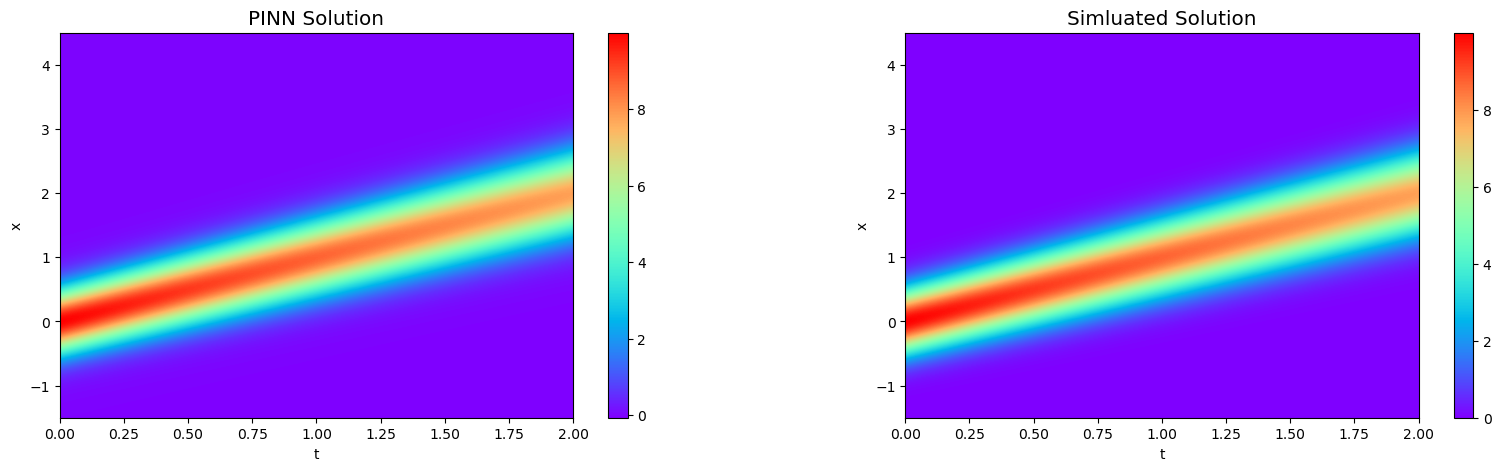

In [23]:
# plot best full-batch loss
hello = PINNs()
prediction = hello.apply(format_params_fn(papas[-1]), data_all)
u = prediction[:,0:1]

fig = plt.figure(figsize=(20, 5))
u_viz = (u.reshape(201, 193)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary  
ax1 = fig.add_subplot(1,2,1)
mesh =ax1.imshow(u_viz, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25); 
plt.colorbar(mesh) 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('PINN Solution', fontsize='x-large'); 

u_true = (label_all.reshape(201, 193)).T 
ext = [0 ,t_T, x_l, x_u]     # plot boundary 
ax2 = fig.add_subplot(1,2,2)
mesh2 = ax2.imshow(u_true, interpolation='bilinear', origin='lower', cmap='rainbow', extent=ext, aspect=.25); 
plt.colorbar(mesh2); 
plt.xlabel('t'); plt.ylabel('x'); 
plt.title('Simluated Solution', fontsize='x-large'); 

jnp.mean(jnp.square(label_all - u))

Write PINN prediction & ground truth to file

In [19]:
#np.save('linear_sgd_minibatch_60s', (u_viz, u_true))